#(Model 3)Random Forest

###Decision Tree
Although decision trees are a method of supervised learning, they are primarily employed to solve classification problems. However, they can also be used to solve regression problems. This classifier is tree-structured, with internal nodes standing in for dataset attributes, branches for decision rules, and leaf nodes for each outcome.

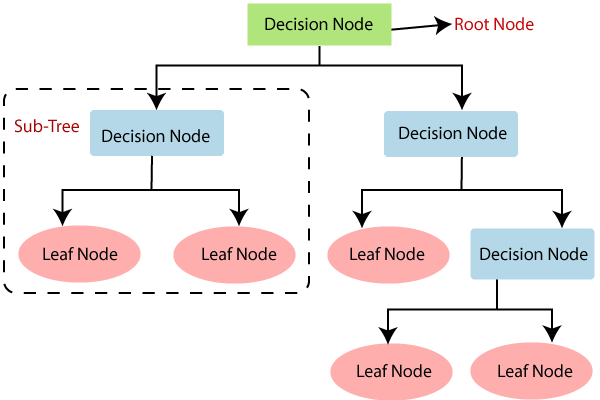


The primary problem that emerges while implementing a decision tree is figuring out which attribute is ideal for the root node and its child nodes. In order to address these issues, a method known as attribute selection measure, or ASM, has been developed. We can quickly choose the ideal attribute for the tree's nodes using this measurement. For ASM, there are two widely used methods, which are:


1. Information Gain

2. Gini Index

Here in our model we used information gain

###Information Gain
The measurement of changes in entropy following the attribute-based dataset segmentation is known as information gain.
It determines the amount of knowledge a feature gives us about a class.

Attribute with the highest information gain is split first in a decision tree algorithm, which always seeks for ways to maximize the value of information gain. It can be computed using the formula given below:

$$ Information Gain= Entropy(S)- [(Weighted Avg) *Entropy(each feature)]  $$

###Entropy
Entropy is a metric to measure the impurity in a given attribute. It specifies randomness in data. Entropy can be calculated as:

$$Entropy(s)= -P(yes)log2 P(yes)- P(no) log2 P(no)$$

Where,

S= Total number of samples

P(yes)= probability of yes

P(no)= probability of no

Decision Tree in itself is a very efficient algorithm but it is more popular for use in another ML algorithm called Random Forest.

###Random Forest
As the name suggests Random Forest is a classifier that uses multiple decision trees on different dataset subsets and averages them to increase the dataset's predictive accuracy.
Rather than depending on a single decision tree, the random forest predicts the outcome based on the majority vote of predictions from each tree.
The lagre number of trees in the forest leads to high accuracy and prevents overfitting.

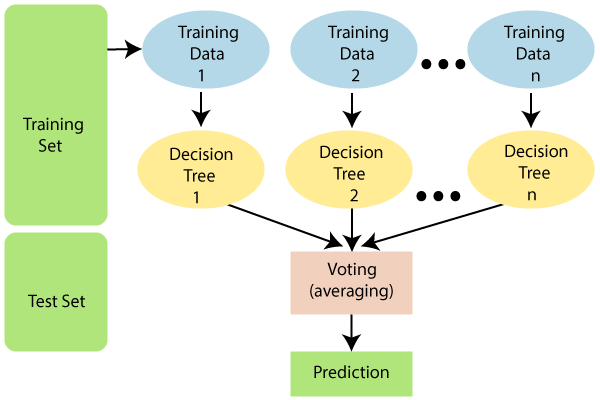

###Working of Random Forest Algorithm
The two stages of Random Forest's operation are the creation of the random forest from the combination of N decision trees and the prediction of each tree generated in the first phase.

The steps following can be used to explain the working process:

**Step 1**: From the training set, choose N data points at random.

**Step 2**: Create the decision trees linked to the chosen data points (subsets) in step two.

**Step 3**: Select the number N for the decision trees you wish to construct.

**Step 4**: Carry out Steps 1 and 2.

**Step 5**: Locate the predictions made by every decision tree for the new data points, then allocate them to the group receiving the majority of votes.






In [ ]:
#importing numpy for working with arrays
#importing pandas for data wrangling and data manipulation purposes
#importing train_test_split to split the data in training and testing sets
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

#setting random seed
np.random.seed(100)

 # Load data from a CSV file using pandas
data = pd.read_csv('german_data_credit_cat.csv')

# Extract features and labels
X = data.iloc[:, :-1].values  # Features (all columns except the last one)
y = data.iloc[:, -1].values   # Target variable(last column)

# defining indices that correspond to categorical data
categorical_indices = [0, 2, 3, 5, 8, 9, 11, 13, 14, 16, 18, 19]

# Define fit function
#The fit method trains the random forest
# by creating multiple decision trees. Each tree is trained on a bootstrap sample.
def fit(X, y, n_trees=10, max_depth=5):
    trees = []
    for _ in range(n_trees):
        boot_index = np.random.choice(len(X), len(X), replace=True)
        tree = DecisionTree(max_depth=max_depth)
        tree.fit(X[boot_index], y[boot_index])
        trees.append(tree)
    return trees

# Define predict function
# The predict method combines predictions from all trees and returns the most common class for each sample.
def predict(X, trees):
    tree_predictions = np.array([tree.predict(X) for tree in trees])
    return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_predictions)


#defining Decision tree class
class DecisionTree:

  #constructor of the class Decision Tree, the attribute Tree stores the tree structure
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

#defining method "fit" for training decision tree and build using parameters X and y
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

#It is a recursive method that builds trees
    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        if len(unique_classes) == 1 or num_samples <= 1 or (self.max_depth is not None and depth == self.max_depth):
            return {'class': Counter(y).most_common(1)[0][0]}

        best_feature, best_value = self._find_best_split(X, y)

        if best_feature is None:
            return {'class': Counter(y).most_common(1)[0][0]}

        left_indices = X[:, best_feature] <= best_value
        right_indices = ~left_indices

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
#The method returns a dictionary representing the current node with information
#about the best split and references to the left and right subtrees.
        return {
            'feature_index': best_feature,
            'split_value': best_value,
            'left': left_subtree,
            'right': right_subtree
        }
#the below method is to find the best split using the entropy,
#It iterates over features and their unique values, calculates
#the entropy for possible splits, and updates the best split if a lower entropy is found.
    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        if num_samples <= 1 or len(np.unique(y)) == 1:
            return None, None

        entropy_parent = self._calculate_entropy(y)

        best_entropy = float('inf')
        best_feature = None
        best_value = None

        for feature_index in range(num_features):
            feature_values = np.unique(X[:, feature_index])

            for value in feature_values:
                left_indices = X[:, feature_index] <= value
                right_indices = ~left_indices

                if np.sum(left_indices) > 0 and np.sum(right_indices) > 0:
                    entropy_left = self._calculate_entropy(y[left_indices])
                    entropy_right = self._calculate_entropy(y[right_indices])

                    weighted_entropy = (np.sum(left_indices) / num_samples) * entropy_left + \
                                       (np.sum(right_indices) / num_samples) * entropy_right

                    if weighted_entropy < best_entropy:
                        best_entropy = weighted_entropy
                        best_feature = feature_index
                        best_value = value

        return best_feature, best_value
#the below method is to calculate entropy of a set of labels
#helps the fir_best_split method to compare between entropies and give the best split
    def _calculate_entropy(self, y):
        classCounts = Counter(y)
        num_samples = len(y)
        entropy = -sum((count / num_samples) * np.log2(count / num_samples) for count in classCounts.values())
        return entropy

    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])

    def _predict_single(self, x, tree):
        if 'class' in tree:
            return tree['class']

        feature_value = x[tree['feature_index']]

        if feature_value <= tree['split_value']:
            return self._predict_single(x, tree['left'])
        else:
            return self._predict_single(x, tree['right'])

# defining one_hot_encoding method
def one_hot_encode(X, categorical_indices):
    encoded_features = []
    for i in range(X.shape[1]):
        if i in categorical_indices:
            unique_values = np.unique(X[:, i])
            encoded_feature = np.zeros((X.shape[0], len(unique_values)))
            for j, value in enumerate(unique_values):
                encoded_feature[:, j] = (X[:, i] == value).astype(int)
            encoded_features.append(encoded_feature)
        else:
            encoded_features.append(X[:, i].reshape(-1, 1))
    return np.concatenate(encoded_features, axis=1)

#applying the one hot encoding on original feature matrix X
X_encoded = one_hot_encode(X, categorical_indices)

# Convert labels to integers
y = y.astype(int)

# splitting data and training and testing in 80-20 ration
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# Training the Random Forest Model
trees = fit(X_train, y_train, n_trees=10, max_depth=5)

# Make predictions
y_pred = predict(X_test, trees)

# # Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")



Accuracy: 0.72
